# Pose detection + position estimation

Generar N frames sintéticos + "labels":
- Procesar los N frames sintéticos con un modelo de pose detection ya entrenado -> keypoints 
- Entrar un modelo de aprendizaje supervisado para predecir la posición de un jugador sobre el campo

### Imports

In [58]:
import torch
import json
import csv
import tqdm
import copy
import os
import mmcv
import keras
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn  

### Parte 1
Procesar los N (14660) frames sintéticos de Blender con un modelo de pose detection ya entrenado 

In [6]:
%run demo/topdown_demo_with_mmdet \
    demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py \
    https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
    configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py \
    https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth \
    --input inputs/1630-16300.mp4 --save-predictions \
    --output-root outputs/Blender/ 

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14660/14660, 2.0 task/s, elapsed: 7379s, ETA:     0s

C:\Users\crv\miniconda3\envs\openmmlab\lib\site-packages\json_tricks\encoders.py:394: UserWarning: json-tricks: numpy scalar serialization is experimental and may work differently in future versions
  warnings.warn('json-tricks: numpy scalar serialization is experimental and may work differently in future versions')


predictions have been saved at outputs/Blender//results_1630-16300.json


### Parte 2
Entrenar un modelo de aprendizaje supervisado (Fully neural network) para predecir la posición (x, y) del jugador sobre la pista a partir de los keypoints calculados anteriormente

 - Tratamiento de datos de entrada (1 solo frame)

In [59]:
# Cargar los keypoints de los jugadores
keypoints = json.load(open('outputs/Blender/results_1630-16300.json'))

# Hay algunos fotogramas de los cuales no ha predecido los keypoints, por lo que hay que suprimirlos
no_keypoints = []
coordenadas_heap = []

X = [] 
for i in range(0, len(keypoints['instance_info'])):
    if len(keypoints['instance_info'][i]['instances']) > 0:
        X.append(keypoints['instance_info'][i]['instances'][0]['keypoints'])
        heap1 = keypoints['instance_info'][i]['instances'][0]['keypoints'][11]
        heap2 = keypoints['instance_info'][i]['instances'][0]['keypoints'][12]
        coordenadas_heap.append([(heap1[0] + heap2[0])/2, (heap1[1] + heap2[1])/2])
    else:
        no_keypoints.append(i)

y = list()

# Cargar las posiciones de la ground truth
with open('outputs/Blender/labels-1630-16300.csv','r') as fp: 
    for line in fp.readlines(): 
        col = line.strip().split(";") 
        new_item = [int(col[1]),int(col[2])] 
        y.append(new_item) 

# coger solo las 14660 primeros fotogramas
y = y[0:14660]

# fotogramas que no se han podido predecir keypoints
no_keypoints.sort(reverse = True)

# eliminar los fotogramas de las cuales no hay keypoints predecidos
for i in no_keypoints:
    y.pop(i)

def normalizar_coordenadas_heap(coordenada, punto):
    punto1 = punto[0] - coordenada[0]
    punto2 = punto[1] - coordenada[1]
    d = math.sqrt(pow(punto1, 2) + pow(punto2, 2))
    offset = 0.00000001
    return [punto1, punto2]


for i in range(0, len(X)):
    for j in range(0, len(X[i])):
        X[i][j] = normalizar_coordenadas_heap(coordenadas_heap[i], X[i][j])
        
for i in range(0, len(y)):
    y[i] = normalizar_coordenadas_heap(coordenadas_heap[i], y[i])
        
# convertirlos en tensores
X = torch.tensor(X, dtype=torch.float32)
X = torch.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
y = torch.tensor(y, dtype=torch.float32)

 - Construcción del modelo

In [60]:
# Modelo secuencial con 4 capas
model = nn.Sequential(
    nn.Linear(34, 25),
    #nn.LeakyReLU(),
    nn.Linear(25, 12),
    #nn.LeakyReLU(),
    nn.Linear(12, 2)
)

# Función de loss: mean square error
loss_fn = nn.MSELoss()
# Optimizador Adam con learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Partición del data en training y test (70-30) aleatoriamente
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

 - Entrenamiento de los datos

In [61]:
# Training parameters
n_epochs = 50
batch_size = 25
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   
best_weights = None
history = []
loss_training = []
loss_testing = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        loss_batch = []
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss_batch.append(float(loss))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
        loss_training.append(min(loss_batch))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    loss_testing.append(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    print('Epoch ', epoch, ': Training loss: ', loss_training[epoch], ' Testing loss: ', loss_testing[epoch])

# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch  0 : Training loss:  49.269065856933594  Testing loss:  128.33558654785156
Epoch  1 : Training loss:  38.266265869140625  Testing loss:  117.72480010986328
Epoch  2 : Training loss:  37.04183578491211  Testing loss:  113.21823120117188
Epoch  3 : Training loss:  29.35540771484375  Testing loss:  111.55125427246094
Epoch  4 : Training loss:  25.625022888183594  Testing loss:  110.8464126586914
Epoch  5 : Training loss:  23.449508666992188  Testing loss:  110.400634765625
Epoch  6 : Training loss:  22.297348022460938  Testing loss:  110.11377716064453
Epoch  7 : Training loss:  21.67657470703125  Testing loss:  109.9569320678711
Epoch  8 : Training loss:  21.330062866210938  Testing loss:  109.8650894165039
Epoch  9 : Training loss:  21.12679672241211  Testing loss:  109.77299499511719
Epoch  10 : Training loss:  21.00369644165039  Testing loss:  109.64232635498047
Epoch  11 : Training loss:  20.931163787841797  Testing loss:  109.46276092529297
Epoch  12 : Training loss:  20.89476

<All keys matched successfully>

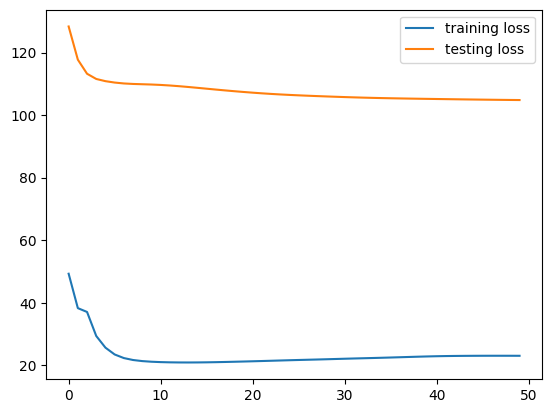

In [62]:
#training and testing loss plots
line1, = plt.plot(loss_training, label='training loss')
line2, = plt.plot(loss_testing, label='testing loss')
plt.legend(handles=[line1, line2])

 - Inferencia con datos reales

In [63]:
data = json.load(open('outputs/TopDown/results_Padel1.json'))
X = []
coordenadas_heap = []
for i in range(0, len(data['instance_info'])):
    X.append(data['instance_info'][i]['keypoints'])
    heap1 = data['instance_info'][i]['keypoints'][11]
    heap2 = data['instance_info'][i]['keypoints'][12]
    coordenadas_heap.append([(heap1[0] + heap2[0])/2, (heap1[1] + heap2[1])/2])

for i in range(0, len(X)):
    for j in range(0, len(X[i])):
        X[i][j] = normalizar_coordenadas_heap(coordenadas_heap[i], X[i][j])    

X = torch.tensor(X, dtype=torch.float32)
X = torch.reshape(X, (len(X), 34))
p = model(X)
p = p.tolist()

def deshacer_normalizacion(punto, coordenada):
    punto1 = punto[0] + coordenada[0]
    punto2 = punto[1] + coordenada[1]
    return [punto1, punto2]

for i in range(0, len(p)):
    p[i] = deshacer_normalizacion(p[i], coordenadas_heap[i])

image = cv2.imread("outputs/TopDown/Padel1.png")

i = cv2.circle(image, (int(p[0][0]),int(p[0][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[1][0]),int(p[1][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[2][0]),int(p[2][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[3][0]),int(p[3][1])), radius=7, color=(0, 0, 255), thickness=-1)
filename = 'savedImage.jpg'
cv2.imwrite(filename, i)

Image.open("savedImage.jpg")

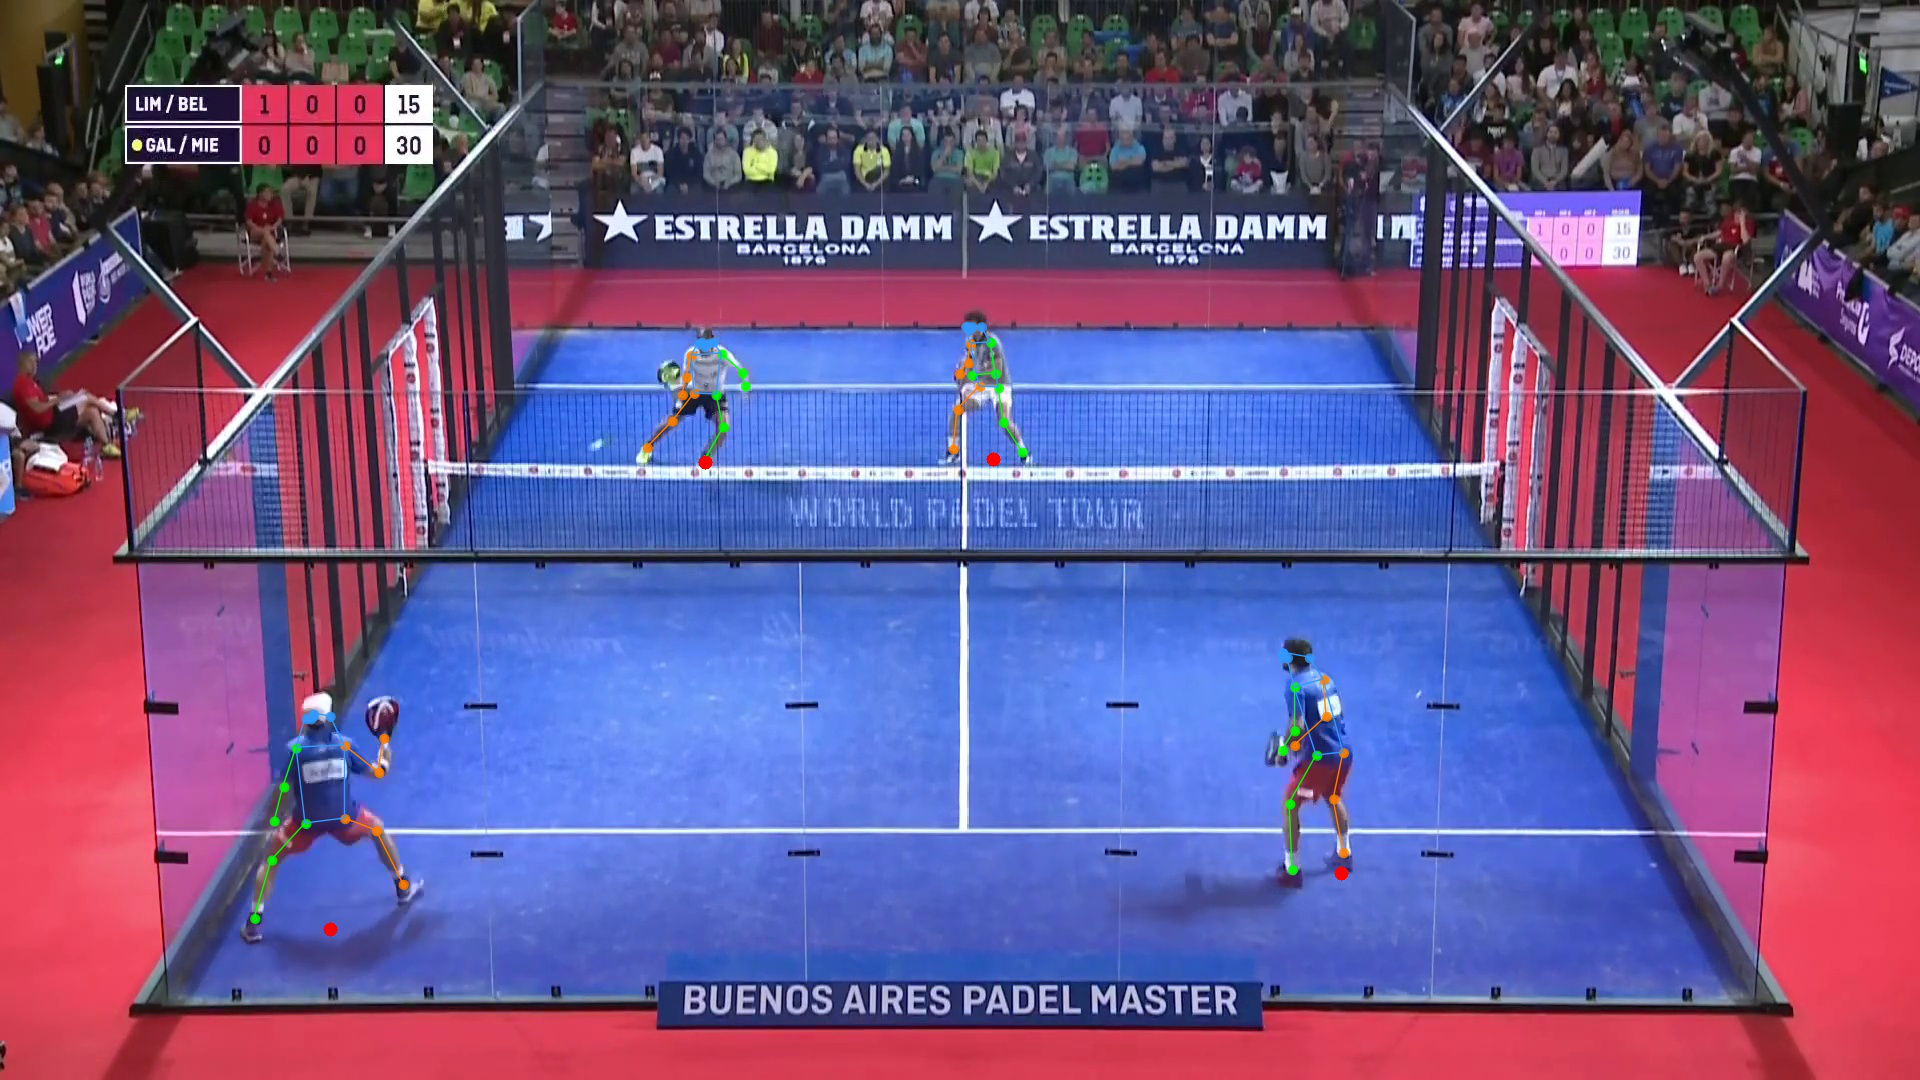

In [64]:
data = json.load(open('outputs/TopDown/results_Padel2.json'))
X = []
coordenadas_heap = []
for i in range(0, len(data['instance_info'])):
    X.append(data['instance_info'][i]['keypoints'])
    heap1 = data['instance_info'][i]['keypoints'][11]
    heap2 = data['instance_info'][i]['keypoints'][12]
    coordenadas_heap.append([(heap1[0] + heap2[0])/2, (heap1[1] + heap2[1])/2])

for i in range(0, len(X)):
    for j in range(0, len(X[i])):
        X[i][j] = normalizar_coordenadas_heap(coordenadas_heap[i], X[i][j])    

X = torch.tensor(X, dtype=torch.float32)
X = torch.reshape(X, (len(X), 34))
p = model(X)
p = p.tolist()

def deshacer_normalizacion(punto, coordenada):
    punto1 = punto[0] + coordenada[0]
    punto2 = punto[1] + coordenada[1]
    return [punto1, punto2]

for i in range(0, len(p)):
    p[i] = deshacer_normalizacion(p[i], coordenadas_heap[i])

image = cv2.imread("outputs/TopDown/Padel2.png")

i = cv2.circle(image, (int(p[0][0]),int(p[0][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[1][0]),int(p[1][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[2][0]),int(p[2][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[3][0]),int(p[3][1])), radius=7, color=(0, 0, 255), thickness=-1)
filename = 'savedImage.jpg'
cv2.imwrite(filename, i)

Image.open("savedImage.jpg")

### Tratamiento de datos de entrada (10 frames)

In [75]:
# Cargar los keypoints de los jugadores
keypoints = json.load(open('outputs/Blender/results_1630-16300.json'))

# Hay algunos fotogramas de los cuales no ha predecido los keypoints, por lo que hay que suprimirlos
no_keypoints = []
coordenadas_heap = []

X = [] 
for i in range(0, len(keypoints['instance_info'])):
    if len(keypoints['instance_info'][i]['instances']) > 0:
        X.append(keypoints['instance_info'][i]['instances'][0]['keypoints'])
        heap1 = keypoints['instance_info'][i]['instances'][0]['keypoints'][11]
        heap2 = keypoints['instance_info'][i]['instances'][0]['keypoints'][12]
        coordenadas_heap.append([(heap1[0] + heap2[0])/2, (heap1[1] + heap2[1])/2])
    else:
        no_keypoints.append(i)

y = list()

# Cargar las posiciones de la ground truth
with open('outputs/Blender/labels-1630-16300.csv','r') as fp: 
    for line in fp.readlines(): 
        col = line.strip().split(";") 
        new_item = [int(col[1]),int(col[2])] 
        y.append(new_item) 

# coger solo las 14660 primeros fotogramas
y = y[0:14660]

# fotogramas que no se han podido predecir keypoints
no_keypoints.sort(reverse = True)

# eliminar los fotogramas de las cuales no hay keypoints predecidos
for i in no_keypoints:
    y.pop(i)

def normalizar_coordenadas_heap(coordenada, punto):
    punto1 = punto[0] - coordenada[0]
    punto2 = punto[1] - coordenada[1]
    d = math.sqrt(pow(punto1, 2) + pow(punto2, 2))
    offset = 0.00000001
    return [punto1, punto2]


for i in range(0, len(X)):
    for j in range(0, len(X[i])):
        X[i][j] = normalizar_coordenadas_heap(coordenadas_heap[i], X[i][j])
        
for i in range(0, len(y)):
    y[i] = normalizar_coordenadas_heap(coordenadas_heap[i], y[i])
    
frames = 13
X_aux = X

X = []
for i in range(frames, len(X_aux) - frames, frames):
    aux = []
    for j in range(i - frames, i + frames):
        for l in range(0, len(X_aux[j])):
            aux.append(X_aux[j][l])
    X.append(aux)

y_aux = y
y = []
for i in range(frames, len(y_aux) - frames, frames):
    aux = []
    for j in range(i - frames, i + frames):
        aux.append(y_aux[j])
    y.append(aux)


# convertirlos en tensores
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
X = torch.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
print(X.shape)
y = torch.tensor(y, dtype=torch.float32)
print(y.shape)
y = torch.reshape(y, (y.shape[0], y.shape[1]*y.shape[2]))
print(y.shape)

torch.Size([1124, 442, 2])
torch.Size([1124, 884])
torch.Size([1124, 26, 2])
torch.Size([1124, 52])


In [76]:
# Modelo secuencial con 4 capas
model = nn.Sequential(
    nn.Linear(884, 400),
    nn.Linear(400, 200),
    nn.Linear(200, 100),
    nn.Linear(100, 52)
)

# Función de loss: mean square error
loss_fn = nn.MSELoss()
# Optimizador Adam con learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Partición del data en training y test (70-30) aleatoriamente
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [77]:
# Training parameters
n_epochs = 50
batch_size = 20
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   
best_weights = None
history = []
loss_training = []
loss_testing = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        loss_batch = []
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss_batch.append(float(loss))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
        loss_training.append(min(loss_batch))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    loss_testing.append(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    print('Epoch ', epoch, ': Training loss: ', loss_training[epoch], ' Testing loss: ', loss_testing[epoch])

# restore model and return best accuracy
model.load_state_dict(best_weights)


Epoch  0 : Training loss:  170.241455078125  Testing loss:  267.36810302734375
Epoch  1 : Training loss:  77.6208267211914  Testing loss:  155.53663635253906
Epoch  2 : Training loss:  50.34397506713867  Testing loss:  138.64041137695312
Epoch  3 : Training loss:  40.95342254638672  Testing loss:  134.1837921142578
Epoch  4 : Training loss:  38.02494430541992  Testing loss:  132.35272216796875
Epoch  5 : Training loss:  36.728515625  Testing loss:  131.19454956054688
Epoch  6 : Training loss:  35.999046325683594  Testing loss:  130.216796875
Epoch  7 : Training loss:  35.537330627441406  Testing loss:  129.29818725585938
Epoch  8 : Training loss:  35.184837341308594  Testing loss:  128.4416961669922
Epoch  9 : Training loss:  34.85475540161133  Testing loss:  127.6796875
Epoch  10 : Training loss:  34.50812530517578  Testing loss:  127.02960205078125
Epoch  11 : Training loss:  34.12842559814453  Testing loss:  126.48963165283203
Epoch  12 : Training loss:  33.70609664916992  Testing l

<All keys matched successfully>

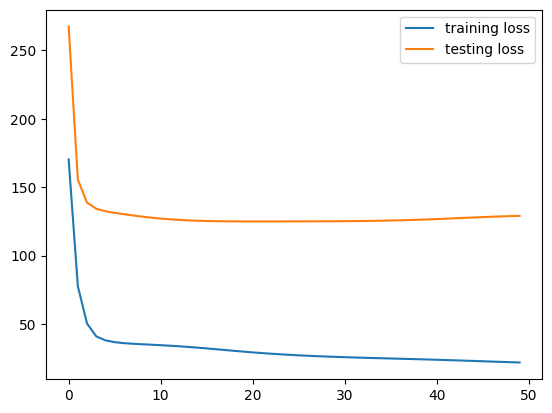

In [78]:
#training and testing loss plots
line1, = plt.plot(loss_training, label='training loss')
line2, = plt.plot(loss_testing, label='testing loss')
plt.legend(handles=[line1, line2])

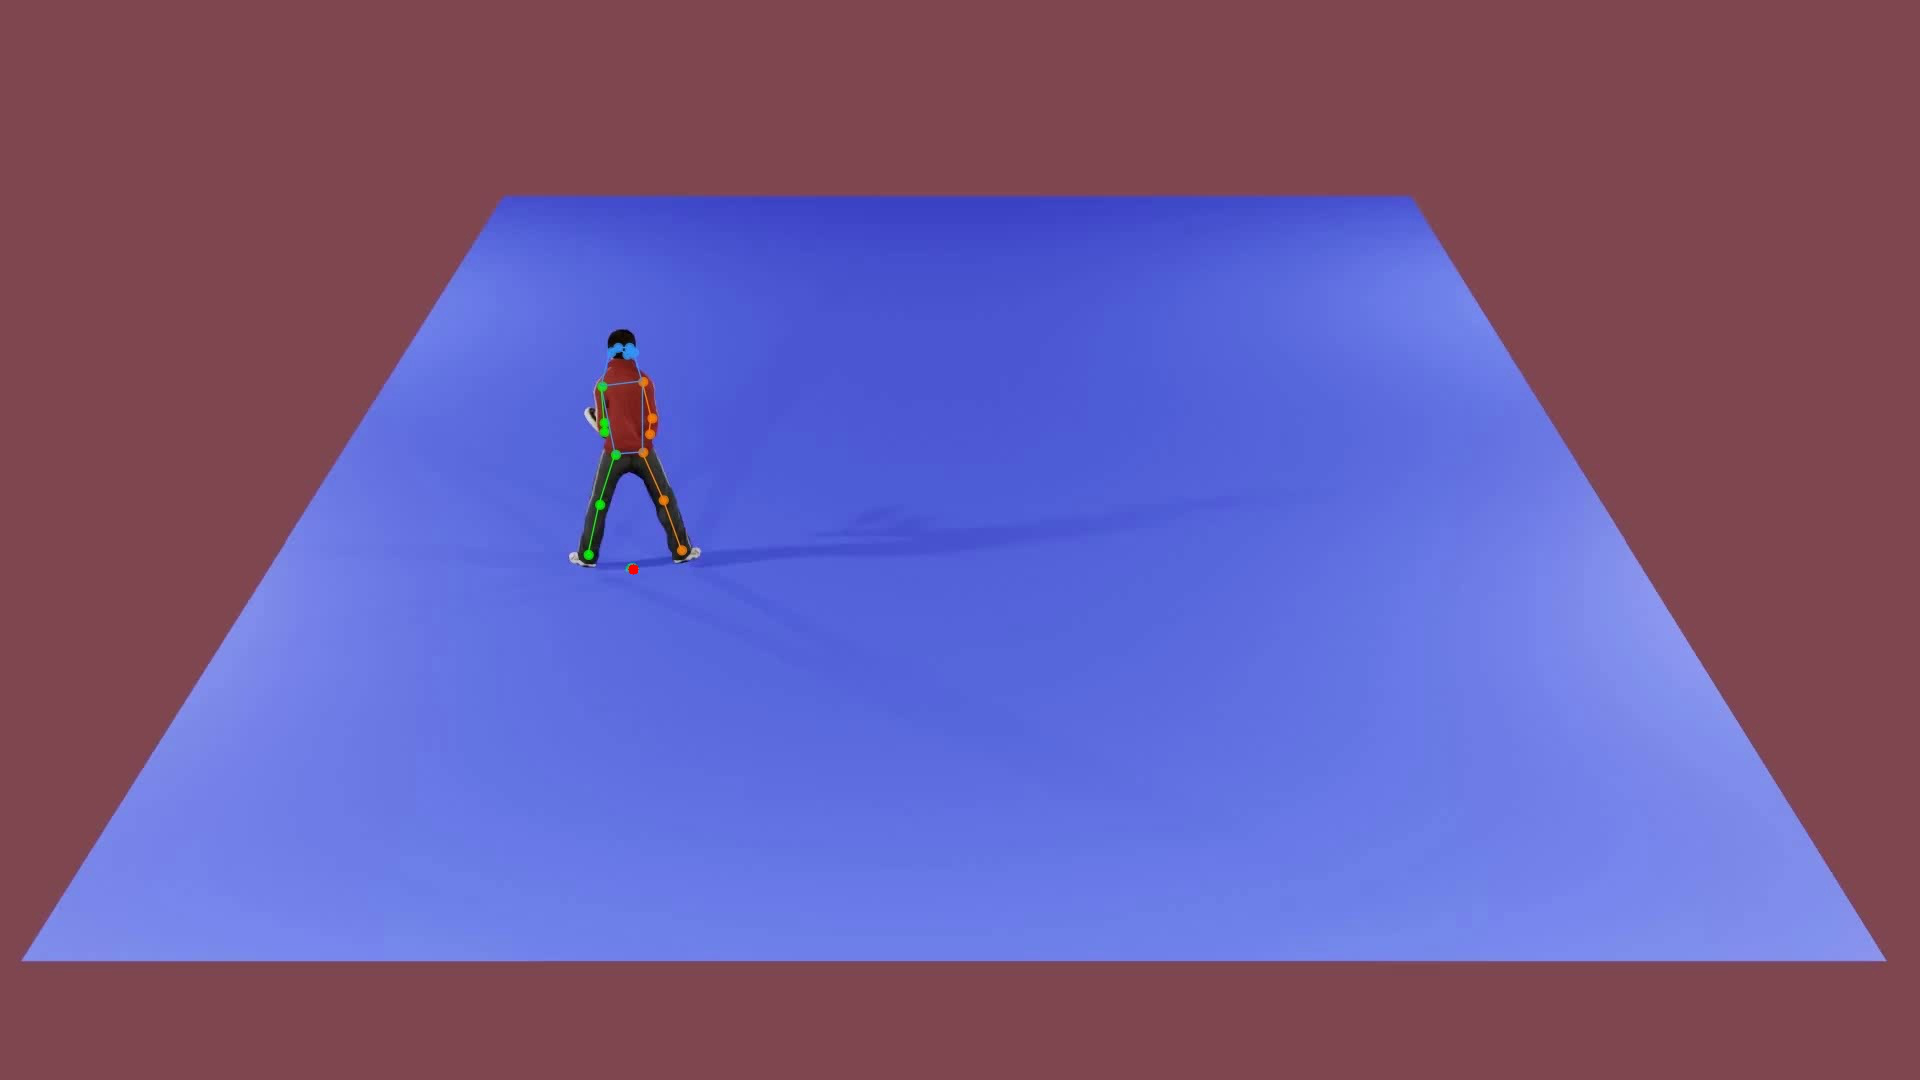

In [82]:
data = json.load(open('outputs/Blender/results_1630-16300.json'))
zeros = []
X = []
coordenadas_heap = []
for i in range(0, len(data['instance_info'])):
    if len(data['instance_info'][i]['instances']) > 0:
        X.append(data['instance_info'][i]['instances'][0]['keypoints'])
        heap1 = data['instance_info'][i]['instances'][0]['keypoints'][11]
        heap2 = data['instance_info'][i]['instances'][0]['keypoints'][12]
        coordenadas_heap.append([(heap1[0] + heap2[0])/2, (heap1[1] + heap2[1])/2])
    else:
        zeros.append(i)
        
zeros.sort(reverse = True)

for i in range(0, len(X)):
    for j in range(0, len(X[i])):
        X[i][j] = normalizar_coordenadas_heap(coordenadas_heap[i], X[i][j])

X = X[0:26]

        
X = torch.tensor(X, dtype=torch.float32)
X = torch.reshape(X, (1, 884))
    
Predictions=model(X)


p = Predictions.tolist()



def deshacer_normalizacion(punto, coordenada):
    punto1 = punto[0] + coordenada[0]
    punto2 = punto[1] + coordenada[1]
    return [punto1, punto2]

for i in range(0, len(p)):
    p[i] = deshacer_normalizacion(p[i], coordenadas_heap[i])


image = cv2.imread("inputs/1.jpg")

i = cv2.circle(image, (int(p[0][0]), int(p[0][1])), radius=5, color=(0, 0, 255), thickness=-1)
filename = 'savedImage.jpg'
cv2.imwrite(filename, i)

Image.open("savedImage.jpg")